In [36]:
import numpy as np # for linear algebra
import pandas as pd # for data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading the Data:

In [7]:
real = pd.read_csv('data/True.csv') 
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake = pd.read_csv('data/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


#### Adding target labels to the data files and concatinating them :

In [12]:
real['target'] = 1
fake['target'] = 0
data = pd.concat([real, fake], axis=0)
data.sample(10)

,title,text,subject,date,target
8812,Trump looks at retired general Flynn as possib...,WASHINGTON (Reuters) - Presumptive Republican ...,politicsNews,"July 9, 2016",1
20383,UK police charge serving soldiers over suspect...,"LONDON (Reuters) - Three men, including two se...",worldnews,"September 11, 2017",1
2185,California sues Trump administration over sanc...,SAN FRANCISCO (Reuters) - California sued the ...,politicsNews,"August 14, 2017",1
13181,Hadi calls on Yemenis to rise up against Houth...,DUBAI (Reuters) - Yemeni President Abd-Rabbu M...,worldnews,"December 4, 2017",1
1716,"Trump to 'slap' foes, embrace friends in first...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"September 15, 2017",1
12789,"Substantive changes to Brexit border text, say...",LONDON (Reuters) - Britain has made substantiv...,worldnews,"December 8, 2017",1
19697,BREAKING EMAIL LEAK: “Bernie needs to be groun...,Hey Bernie how s that whole Queen of Wall Stre...,left-news,"Nov 1, 2016",0
19731,MUST WATCH: Trump Supporter Unleashes Truth On...,Brunell Donald-Kyei: We want tougher immigrat...,left-news,"Oct 26, 2016",0
1635,China urges North Korea not to go further in a...,UNITED NATIONS (Reuters) - China’s foreign min...,politicsNews,"September 21, 2017",1
19385,VACATIONING LAME-DUCK OBAMA Ready To Announce ...,The Obama administration plans to announce on ...,left-news,"Dec 29, 2016",0


#### Text Cleaning:

In [14]:
def clean(text):
    #1. Remove punctuation
    translator1 = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator1)
    
    #2. Convert to lowercase characters
    text = text.lower()
    
    #3. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    
    return text

# Apply cleaning to title and text in dataset
data['title'] = data['title'].apply(clean)
data['text'] = data['text'].apply(clean)
data.sample(10)

,title,text,subject,date,target
12801,china jails 21 people 2015 nursing home fire x...,shanghai reuters china jailed 21 people roles ...,worldnews,"December 8, 2017",1
8523,obama administration releases redacted version...,washington reuters obama administration releas...,politicsNews,"August 6, 2016",1
11776,arab coalition says keep yemen port open air r...,aden reuters saudi led coalition fighting yeme...,worldnews,"December 20, 2017",1
4104,trump urges u n reform make u investment worth...,washington reuters president donald trump comp...,politicsNews,"April 24, 2017",1
20693,fema may run funds friday senators,washington reuters u federal emergency managem...,worldnews,"September 7, 2017",1
5375,trump defense chief sees military collaboratio...,brussels reuters u president donald trump’s de...,politicsNews,"February 16, 2017",1
20903,video hillary clinton want see,spread everywhere,left-news,"Mar 9, 2016",0
8488,gross gop candidates using military vets human...,least two republican campaigns using veteran g...,News,"January 28, 2016",0
10489,appellate judges garland srinivasan considered...,washington reuters white house vetting federal...,politicsNews,"March 5, 2016",1
11568,major cosmetic company announces plans release...,cosmetics brand lush popular among young girls...,politics,"Feb 26, 2017",0


In [19]:
# Hyperparameters for title and text
vocab_size = 100000
embedding_dim_title = 128
max_length_title = 40
embedding_dim_text = 500
max_length_text = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
test_ratio = .3
embedding_dim = 500
max_length_text = 500

#### Tokenization and Padding of the data:

In [15]:
def preprocessing(data, dependent_column=None, target='target', max_len=40):
    train_X, test_X, train_y, test_y = train_test_split(data[dependent_column], data[target], test_size=test_ratio)
    tokenizer = Tokenizer(num_words=vocab_size,
                          oov_token=oov_tok)
    tokenizer.fit_on_texts(train_X)
    train_sequences = tokenizer.texts_to_sequences(train_X)
    train_padded = pad_sequences(train_sequences, maxlen=max_len,
                                padding=padding_type,
                                truncating=trunc_type)
    test_sequences = tokenizer.texts_to_sequences(test_X)
    test_padded = pad_sequences(test_sequences, maxlen=max_len,
                               padding=padding_type,
                               truncating=trunc_type)
    return train_padded, test_padded, train_y, test_y

In [20]:
train_padded, test_padded, train_y, test_y = preprocessing(data, dependent_column='title', max_len=max_length_title)

### BLSTM:

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model.add(tf.keras.layers.Dense(embedding_dim, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

In [30]:
history = model.fit(train_padded[3302:6302], train_y[3302:6302], validation_data=(train_padded[6303:6603], train_y[6303:6603]), epochs=2, batch_size=64)

Train on 3000 samples, validate on 300 samples
Epoch 1/2
3000/3000 [==============================] - 112s 37ms/sample - loss: 0.1599 - acc: 0.9407 - val_loss: 0.1100 - val_acc: 0.9600
Epoch 2/2
3000/3000 [==============================] - 131s 44ms/sample - loss: 0.0201 - acc: 0.9920 - val_loss: 0.1799 - val_acc: 0.9400


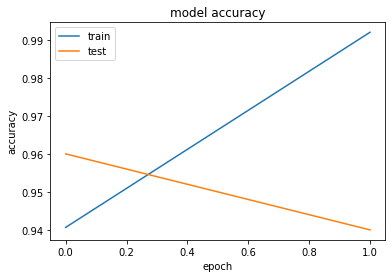

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
pred = model.predict(test_padded)

In [42]:
r2_score(test_y, pred) 

0.7991409886341365

### Adding a conv layer and training on Text:

In [49]:
train_padded, test_padded, train_y, test_y = preprocessing(data, dependent_column='text', max_len=max_length_title)

In [50]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=8,strides=1,activation='relu',padding='same'))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model.add(tf.keras.layers.Dense(embedding_dim, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 500)         50000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          128032    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000)              2132000   
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 501       
Total params: 52,761,033
Trainable params: 52,761,033
Non-trainable params: 0
_________________________________________________________________


In [52]:
train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

history = model.fit(train_padded[0:6000], train_y[0:6000], validation_data=(train_padded[6001:6603], train_y[6001:6603]), epochs=2, batch_size=64)

Train on 6000 samples, validate on 602 samples
Epoch 1/2
6000/6000 [==============================] - 190s 32ms/sample - loss: 0.0952 - acc: 0.9547 - val_loss: 0.0168 - val_acc: 0.9967
Epoch 2/2
6000/6000 [==============================] - 206s 34ms/sample - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0151 - val_acc: 0.9983


In [53]:
pred = model.predict(test_padded)

In [56]:
r2_score(test_y, pred) 

0.9918605204601003